# FEIS Dataset - Transduction

## Load Dataset

In [2]:
from lib import FEISDataset

# Participant
pt       = "01\\"

# EEG Path
root_dir = "C:\\Users\\win8t\\OneDrive\\Desktop\\scottwellington-FEIS-7e726fd\\experiments\\"
root_dir += pt
csv_path = root_dir + "stimuli.csv"

# Audio Path
audio_dir  = "C:\\Users\\win8t\\OneDrive\\Desktop\\scottwellington-FEIS-7e726fd\\wavs\\"
audio_dir  += pt
audio_dir  += "combined_wavs\\"

dataset = FEISDataset(csv_path=csv_path, audio_dir=audio_dir)

In [2]:
example_idx = 0

dataset[example_idx]

{'label': 'goose',
 'audio_raw': array([-1.44888063e-07,  1.64976802e-07, -1.79901090e-07, ...,
        -6.36455455e-06,  2.58709041e-05,  5.69648720e-06]),
 'audio_feats': array([[-11.506246 , -11.511651 , -11.510628 , ..., -11.512603 ,
         -11.512728 , -11.512871 ],
        [-11.499132 , -11.510148 , -11.510438 , ..., -11.512479 ,
         -11.5125475, -11.512905 ],
        [-11.508287 , -11.504744 , -11.449142 , ..., -11.512265 ,
         -11.512279 , -11.512864 ],
        ...,
        [-11.496371 , -11.504329 , -11.476278 , ..., -11.5123005,
         -11.512506 , -11.512892 ],
        [-11.503679 , -11.512364 , -11.511157 , ..., -11.512687 ,
         -11.512702 , -11.512904 ],
        [-11.49732  , -11.49896  , -11.47645  , ..., -11.512561 ,
         -11.512614 , -11.512877 ]], dtype=float32),
 'eeg_raw': array([[  -8.79978963,  -12.08937257,    5.17867386, ...,  -46.98188215,
          -29.50988593,    1.70307311],
        [  -9.81281564,  -11.89624354,   -2.01210608, ...,  -

## Data Visualisation

### Raw EEG (Drift Removed)

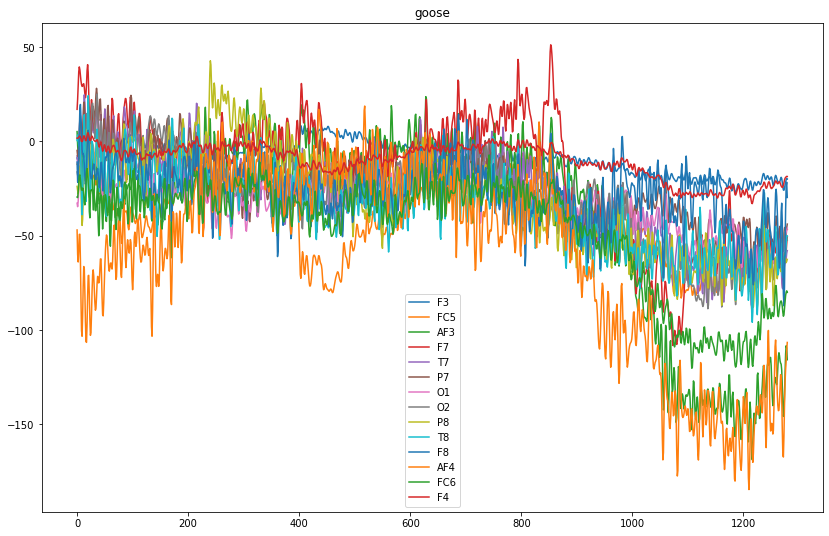

In [73]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)

eeg_data = dataset[example_idx]["eeg_raw"]
plt.title(dataset[example_idx]["label"])
for i in range(eeg_data.shape[1]):
    cur_channel = eeg_data[:, i]
    ch_name = dataset.channels[i]
    plt.plot(cur_channel, label=ch_name)
plt.legend()

### EEG Features (Digital Voicing)

eeg_feats.shape: (425, 70)


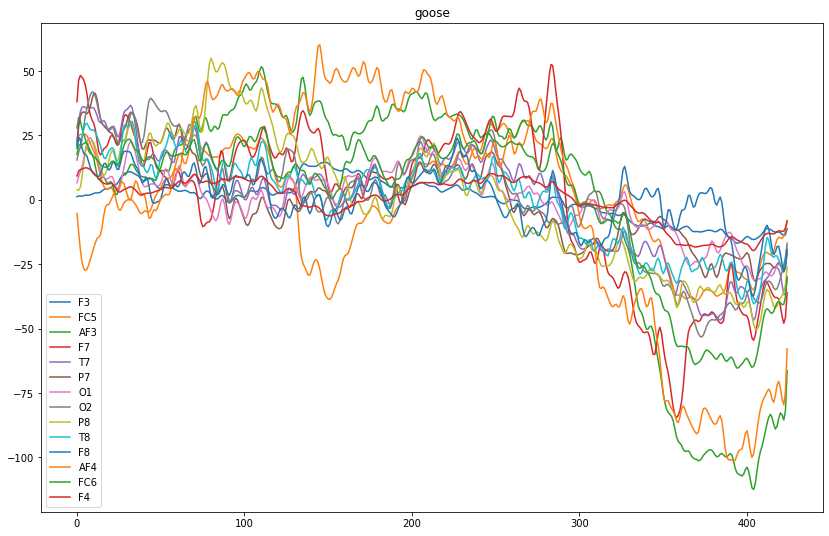

In [74]:
eeg_data = dataset[example_idx]["eeg_feats"]
plt.title(dataset[example_idx]["label"])
print("eeg_feats.shape:", eeg_data.shape)
for i in range(len(dataset.channels)):
    cur_channel = eeg_data[:, (i*5)+0]
    ch_name = dataset.channels[i]
    plt.plot(cur_channel, label=ch_name)
plt.legend()

### Raw Audio

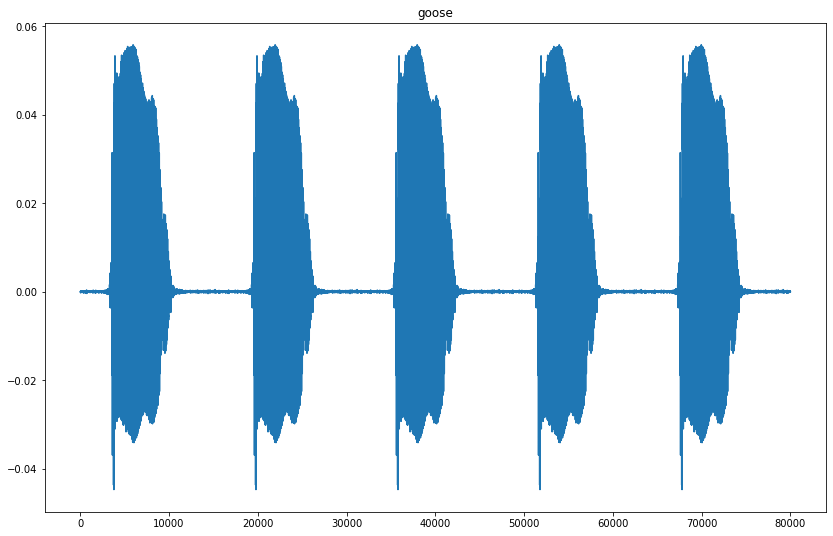

In [33]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 9)
plt.title(dataset[example_idx]["label"])
plt.plot(dataset[example_idx]["audio_raw"])

### Plot Audio Features (Mel Spectrogram)

In [3]:
import numpy as np
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

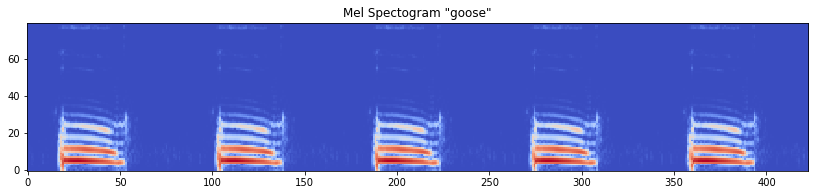

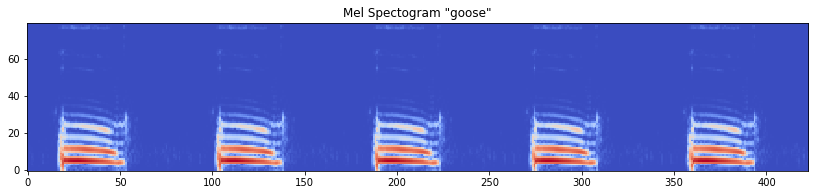

In [35]:
example_mel_spec = dataset[example_idx]["audio_feats"]
plot_mel_spectrogram(example_mel_spec, dataset[example_idx]["label"])

In [36]:
print(set(dataset.labels))

{'n', 'p', 'zh', 'ng', 'm', 'thought', 'z', 'v', 'k', 'sh', 'trap', 'f', 's', 'goose', 't', 'fleece'}


## Single Synthesis (Overfit)

### Model

In [75]:
import torch.nn as nn
import torch.nn.functional as F

from lib.transformer import *

class ProposedModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        # Transformer
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x

In [76]:
import torch
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

ins = dataset.num_features
outs = 80 # mel bins
model = ProposedModel(\
        model_size=ins,
        dropout=0.2,
        num_layers=8,
        n_heads=2,
        dim_feedforward=3072,
        out_dim=outs).to(device)

### Training

In [77]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

synth_example = dataset[example_idx]

X = torch.tensor(synth_example["eeg_feats"],   dtype=torch.bfloat16).to(device)
y = torch.tensor(synth_example["audio_feats"], dtype=torch.bfloat16).to(device)

clip_len = min(X.shape[0], y.shape[0])

X = X[:clip_len, :ins]
y = y[:clip_len, :]

print("X SHAPE, Y SHAPE:", X.shape, y.shape)

X = torch.unsqueeze(X, 0)
y = torch.unsqueeze(y, 0)

lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 20_000 # 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

for i in range(epochs):
    #optim.zero_grad()

    with torch.autocast(
        enabled=amp,
        dtype=torch.bfloat16,
        device_type=device):

        #print("model inp:", X.shape, X.dtype)

        pred = model(X)

        #print("model outp:", pred.shape, pred.dtype)

        if y.shape[1] < pred.shape[1]:
            pred = pred[:, :y.shape[1], :]
            #print("model outp (clipped):", pred.shape, pred.dtype)
            #print("y:", y.shape)

        loss = criteria(pred, y)

        if i % 100 == 0:
            pred_s.append(pred.cpu().detach())
            losses.append(loss.item())

        # plt.plot(loss.item())

            print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

X SHAPE, Y SHAPE: torch.Size([423, 70]) torch.Size([423, 80])
0 119.9869384765625
100 45.84180450439453
200 10.715622901916504
300 2.9089274406433105
400 1.5413235425949097
500 1.0081555843353271
600 0.634207010269165
700 0.41852566599845886
800 0.30735406279563904
900 0.24259160459041595
1000 0.19649247825145721
1100 0.16119784116744995
1200 0.1361140012741089
1300 0.1181882843375206
1400 0.09579632431268692
1500 0.081134133040905
1600 0.07372454553842545
1700 0.061332352459430695
1800 0.05399197340011597
1900 0.047384534031152725
2000 0.041774850338697433
2100 0.036882929503917694
2200 0.03370301425457001
2300 0.03207700699567795
2400 0.027130624279379845
2500 0.027321163564920425
2600 0.022547904402017593
2700 0.021798547357320786
2800 0.01957816630601883
2900 0.018346095457673073
3000 0.017416568472981453
3100 0.016760043799877167
3200 0.015641219913959503
3300 0.01571212150156498


KeyboardInterrupt: 

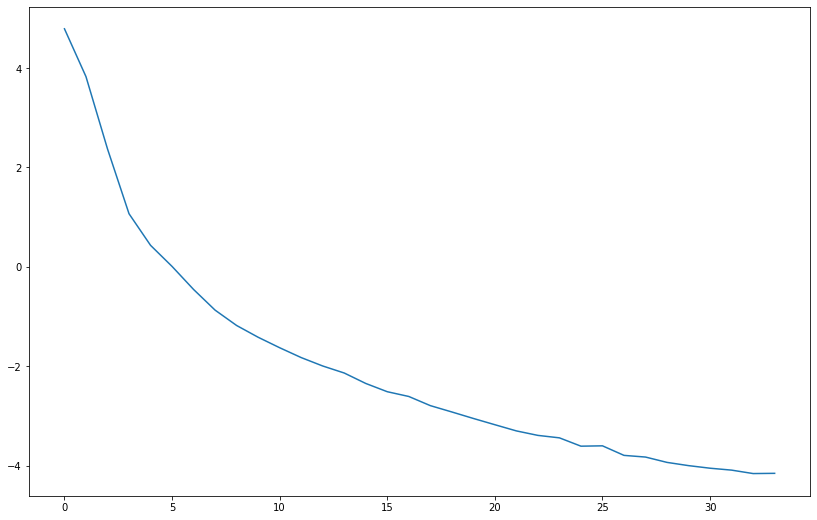

In [78]:
plt.plot(np.log(losses))

### Plot Pred

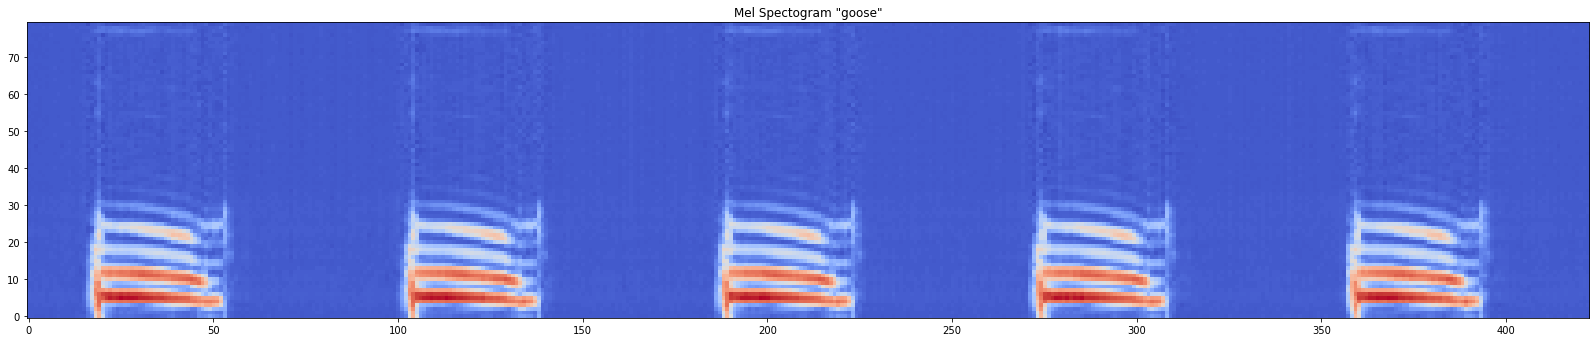

In [79]:
plt.rcParams["figure.figsize"] = (14*2, 9*2)

y = torch.squeeze(pred_s[len(pred_s) - 1], 0).float()
_ = plot_mel_spectrogram(y, synth_example["label"])

### Plot Original

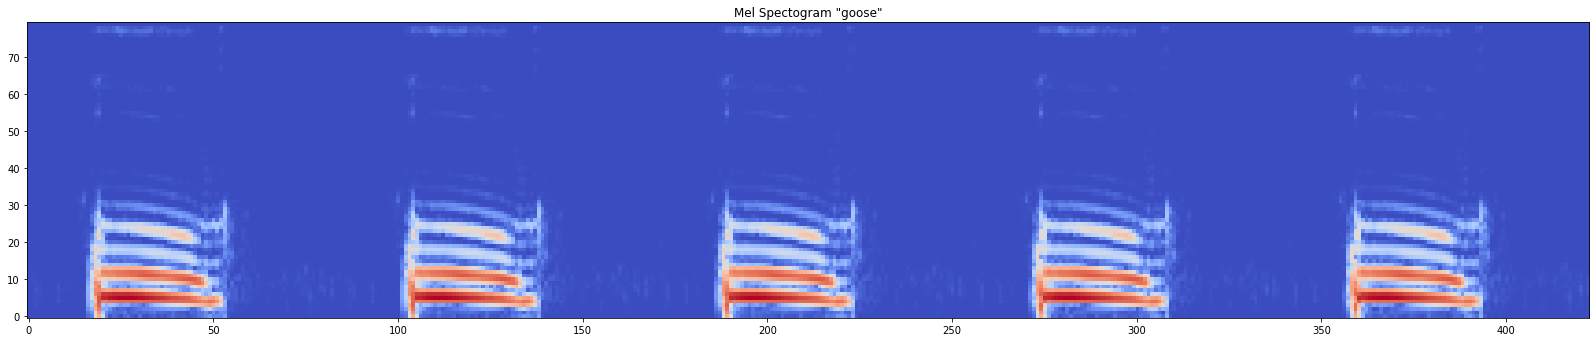

In [80]:
cur_ex = dataset[example_idx]
_ = plot_mel_spectrogram(cur_ex["audio_feats"], cur_ex["label"])

## Multiple Synthesis (Overfit)

### Model

In [56]:
import torch.nn as nn
import torch.nn.functional as F

from lib.transformer import *

class ProposedModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        # Transformer
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x

In [57]:
import torch
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

ins = dataset.num_features
outs = 80 # mel bins
model = ProposedModel(\
        model_size=ins,
        dropout=0.2,
        num_layers=8,
        n_heads=2,
        dim_feedforward=3072,
        out_dim=outs).to(device)

### Training

In [6]:
set(dataset.labels)

{'f',
 'fleece',
 'goose',
 'k',
 'm',
 'n',
 'ng',
 'p',
 's',
 'sh',
 't',
 'thought',
 'trap',
 'v',
 'z',
 'zh'}

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.nn.utils.rnn import pad_sequence

from torch.cuda.amp.grad_scaler import GradScaler

# Create one large batch of all examples (speed up training)
# If including a lot of the dataset, turn this off as it will not fit in VRAM
PAD_SEQ = True

X_s = []
y_s = []

flatten = lambda lst: [item for sublist in lst for item in sublist]

target_labels  = ["n"]
target_idx_s   = [dataset.get_label_idxs(target_label)
                  for target_label in target_labels]
synth_examples = [[dataset[target_idx]
                   for target_idx in target_idxs]
                  for target_idxs in target_idx_s]
synth_examples = flatten(synth_examples)

print(target_labels, len(synth_examples))

for synth_example in synth_examples:
    X = torch.tensor(synth_example["eeg_feats"]).to(device)
    y = torch.tensor(synth_example["audio_feats"]).to(device)
    clip_len = min(X.shape[0], y.shape[0])
    X = X[:clip_len, :ins]
    y = y[:clip_len, :]
    X = torch.unsqueeze(X, 0)
    y = torch.unsqueeze(y, 0)
    X_s.append(X)
    y_s.append(y)

if PAD_SEQ:
    X_s = pad_sequence(X_s, batch_first=True)
    y_s = pad_sequence(y_s, batch_first=True)
    X_s = torch.squeeze(X_s, 1)
    y_s = torch.squeeze(y_s, 1)

print(X_s.shape, y_s.shape)

lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 20_000 # 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

model.train()

for i in range(epochs):
    optim.zero_grad()

    cur_losses = []

    if PAD_SEQ:
        with torch.autocast(
            enabled=amp,
            dtype=torch.bfloat16,
            device_type=device):
            pred = model(X_s)
            loss = criteria(pred, y_s)
            cur_losses.append(loss)
    else:
        for X, y in zip(X_s, y_s):
            with torch.autocast(
                enabled=amp,
                dtype=torch.bfloat16,
                device_type=device):

                pred = model(X) 
                loss = criteria(pred, y)
                cur_losses.append(loss)
    
    loss = sum(cur_losses)

    if i % 100 == 0:
        losses.append(loss.item())
        print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()

['n'] 10
torch.Size([10, 423, 70]) torch.Size([10, 423, 80])
0 115.11493682861328
100 43.22348403930664
200 10.400738716125488
300 3.421276092529297
400 2.8308780193328857
500 2.8047993183135986
600 2.803863763809204
700 2.805380344390869
800 2.802964925765991
900 2.8080575466156006
1000 2.80627179145813
1100 2.8051743507385254
1200 2.8057138919830322
1300 1.3111289739608765
1400 0.4904315173625946
1500 0.2837012708187103
1600 0.194101944565773
1700 0.153528094291687
1800 0.11809646338224411
1900 0.09683996438980103
2000 0.08271721005439758
2100 0.06979410350322723
2200 0.06233077496290207
2300 0.05374014005064964
2400 0.047614745795726776
2500 0.04530325531959534
2600 0.03988280147314072
2700 0.03675895929336548


KeyboardInterrupt: 

In [59]:
out_s = []

model.eval()

if PAD_SEQ:
    out_X_s = torch.split(X_s, X_s.shape[0], dim=0)
    out_y_s = torch.split(X_s, y_s.shape[0], dim=0)
else:
    out_X_s = X_s
    out_y_s = y_s

for X, y in zip(out_X_s, out_y_s):
    with torch.no_grad():
        pred = model(X)
        cur_out = pred.cpu().detach()
        if cur_out.shape[0] == X.shape[0]:
            out_s = cur_out
        else:
            out_s.append(cur_out)

### Plot Pred

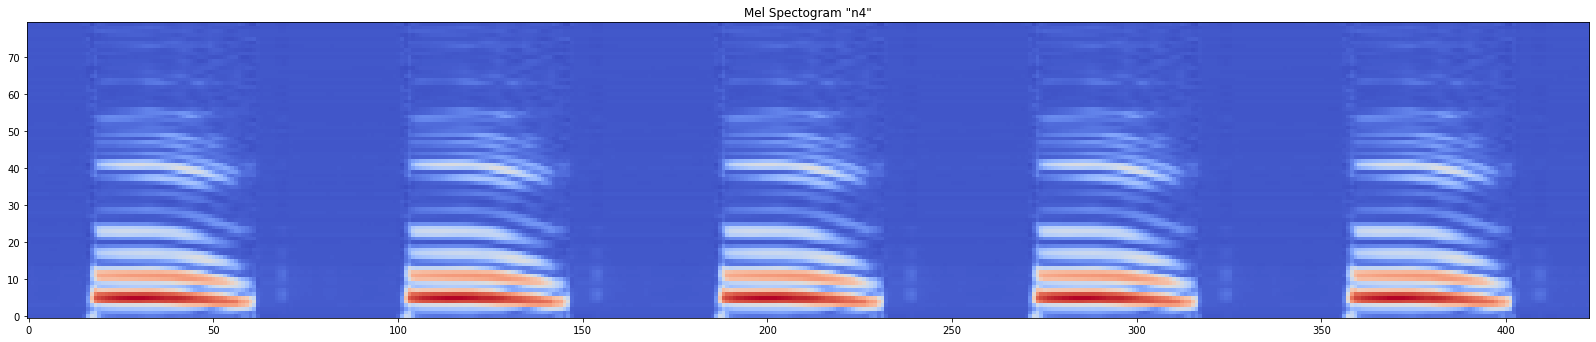

In [61]:
plt.rcParams["figure.figsize"] = (14*2, 9*2)

plot_pred_idx = 4
y = torch.squeeze(out_s[plot_pred_idx], 0).float()
_ = plot_mel_spectrogram(y, synth_examples[plot_pred_idx]["label"] + str(plot_pred_idx))

### Plot Original

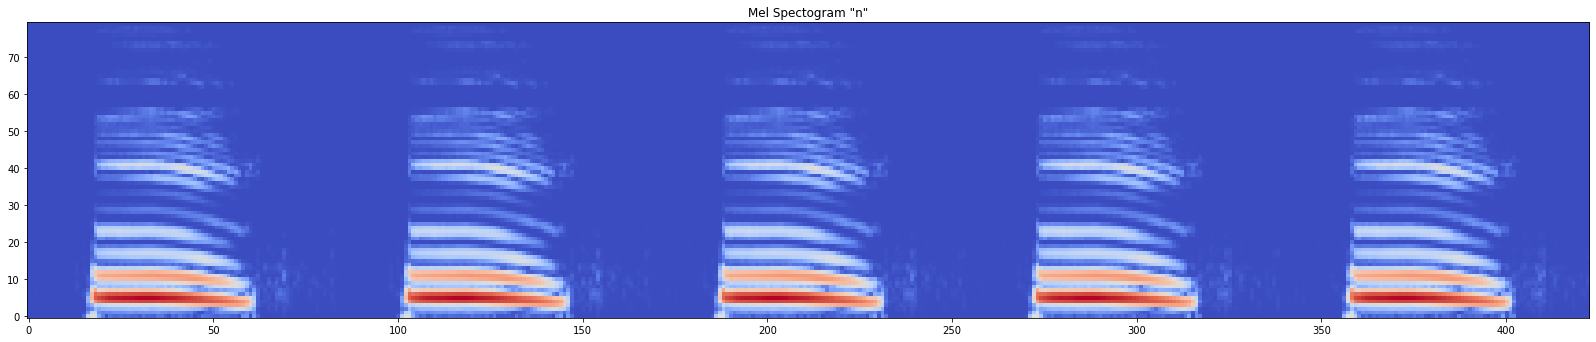

In [62]:
_ = plot_mel_spectrogram(synth_examples[plot_pred_idx]["audio_feats"], synth_examples[plot_pred_idx]["label"])

## Single Synthesis (Generalisation)

### Model

In [81]:
import torch.nn as nn
import torch.nn.functional as F

from lib.transformer import *

class ProposedModel(nn.Module):
    def __init__(self,
                 model_size,
                 dropout=0.2,
                 num_layers=6,
                 n_heads=8,
                 dim_feedforward=3072,
                 out_dim=80):
        super().__init__()

        encoder_layer = TransformerEncoderLayer(
            d_model=model_size,
            nhead=n_heads,
            relative_positional=True,
            relative_positional_distance=100,
            dim_feedforward=dim_feedforward,
            dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.w_out = nn.Linear(model_size, out_dim)
    
    def forward(self, x):
        # Transformer
        x = x.transpose(0, 1)
        x = self.transformer(x)
        x = x.transpose(0, 1)

        # Final MLP
        x = self.w_out(x)

        return x

In [82]:
import torch
import random

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

ins = dataset.num_features
outs = 80 # mel bins
model = ProposedModel(\
        model_size=ins,
        dropout=0.2,
        num_layers=8,
        n_heads=2,
        dim_feedforward=3072,
        out_dim=outs).to(device)

### Training

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.cuda.amp.grad_scaler import GradScaler

synth_example = dataset[example_idx]

X = torch.tensor(synth_example["eeg_feats"],   dtype=torch.bfloat16).to(device)
y = torch.tensor(synth_example["audio_feats"], dtype=torch.bfloat16).to(device)

clip_len = min(X.shape[0], y.shape[0])

X = X[:clip_len, :ins]
y = y[:clip_len, :]

print("X SHAPE, Y SHAPE:", X.shape, y.shape)

X = torch.unsqueeze(X, 0)
y = torch.unsqueeze(y, 0)

lr = 5e-4 # 1e-3 # 5e-4 # 1e-3
optim = torch.optim.Adam(model.parameters(), lr=lr)

amp = True

epochs = 20_000 # 10_000

scaler = GradScaler()

criteria = nn.MSELoss()

pred_s = []
losses = []

for i in range(epochs):
    #optim.zero_grad()

    with torch.autocast(
        enabled=amp,
        dtype=torch.bfloat16,
        device_type=device):

        #print("model inp:", X.shape, X.dtype)

        pred = model(X)

        #print("model outp:", pred.shape, pred.dtype)

        if y.shape[1] < pred.shape[1]:
            pred = pred[:, :y.shape[1], :]
            #print("model outp (clipped):", pred.shape, pred.dtype)
            #print("y:", y.shape)

        loss = criteria(pred, y)

        if i % 100 == 0:
            pred_s.append(pred.cpu().detach())
            losses.append(loss.item())

        # plt.plot(loss.item())

            print(i, loss.item())

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()

    # scheduler.step()